In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# This will reload imports before executing code, allowing you to easily change contents of custom scripts
%load_ext autoreload
%autoreload 2

# Stay classification: cluster-splitting

## Current evaluation

### Pros
* can separate sequence and identify rudimentary clusters

### Cons
* can't distinguish stays from travels 
    * nothing created to do so.

## ToDos

* check that the newly split clusters are 
    * contain enough samples
    * have a total duration longer than the threshold
    * are not embedded within another cluster
* check that there are no embedded clusters
    * times don't overlap $\checkmark\to$ have function
    * if refined clusters are embedded, check if one cluster is noise
* check the stddev of the refined clusters are smaller


## Future directions

It may be best to use this as an initial pass for the box, or _any_, method, thereby confining the errors and speeding up the compute.

In [3]:
import numpy as np
import pandas as pd

In [4]:
import os, sys
sys.path.append('/home/sandm/Notebooks/stay_classification/src/')

In [5]:
# #############################################################################
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, 10)]

from random import shuffle

In [7]:
shuffle(colors)

# Sythetic data

In [8]:
from synthetic_data.trajectory import get_stay_segs, get_adjusted_stays
from synthetic_data.trajectory_class import get_rand_traj


event_frac = 0.1 #rand_range(1,0.01,0.001)[0]
duplicate_frac = 0.0 #rand_range(1,0.3,0.05)[0]

configs = {
    'time_thresh':1/6,
    'dist_thresh':0.5,
    'event_frac':event_frac,
    'duplicate_frac':duplicate_frac,    
    'noise_min':0.02,
    'noise_max':0.15
}



time_arr, raw_arr, noise_arr, segments = get_rand_traj(configs)
t_segs, x_segs = get_stay_segs(get_adjusted_stays(segments, time_arr))

In [9]:
from synthetic_data.plotting import plot_trajectory

<Figure size 1440x720 with 0 Axes>

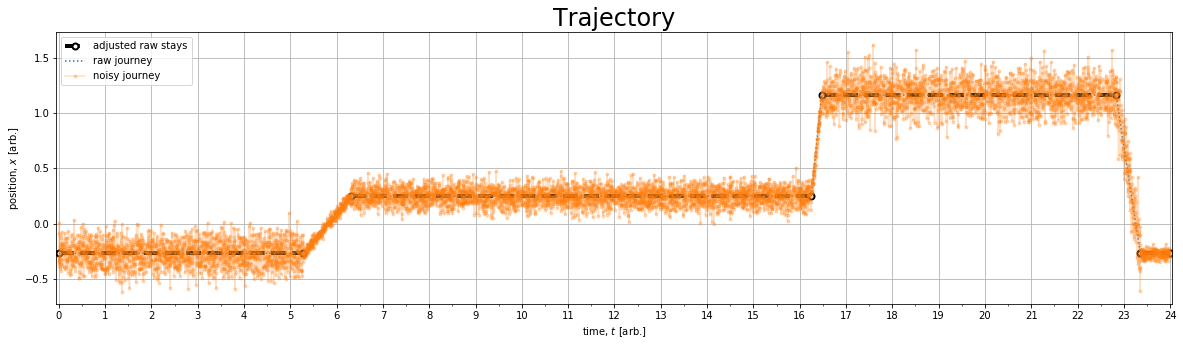

In [10]:
plt.figure(figsize=(20,10))
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

# Clustering

## Split the clusters which have a temporal gap

In [11]:
time_thresh = 1/6
eps=0.25

In [12]:
clusters = list(range(time_arr.size))

In [14]:
from stay_classification.splitting_classifier.splitting_classifier import get_clusters

### Basic cluster identification

In [15]:
clusters = get_clusters(time_arr, noise_arr, eps, time_thresh)
len(clusters)

27

In [16]:
print("just the end-point indices:")
for clust in clusters:
    print(f"[{clust[0]},{clust[-1]}]")

just the end-point indices:
[1,110]
[113,169]
[187,344]
[346,424]
[648,748]
[769,843]
[847,984]
[1056,1137]
[1356,1426]
[1469,1641]
[1644,1761]
[1764,1827]
[1833,2087]
[2089,2378]
[2381,5110]
[5112,5755]
[5758,5919]
[5960,6023]
[6185,6263]
[6403,6467]
[6577,6681]
[7091,7199]
[7344,7426]
[7748,7881]
[7892,7964]
[8017,8100]
[8404,8635]


### Raw plotting

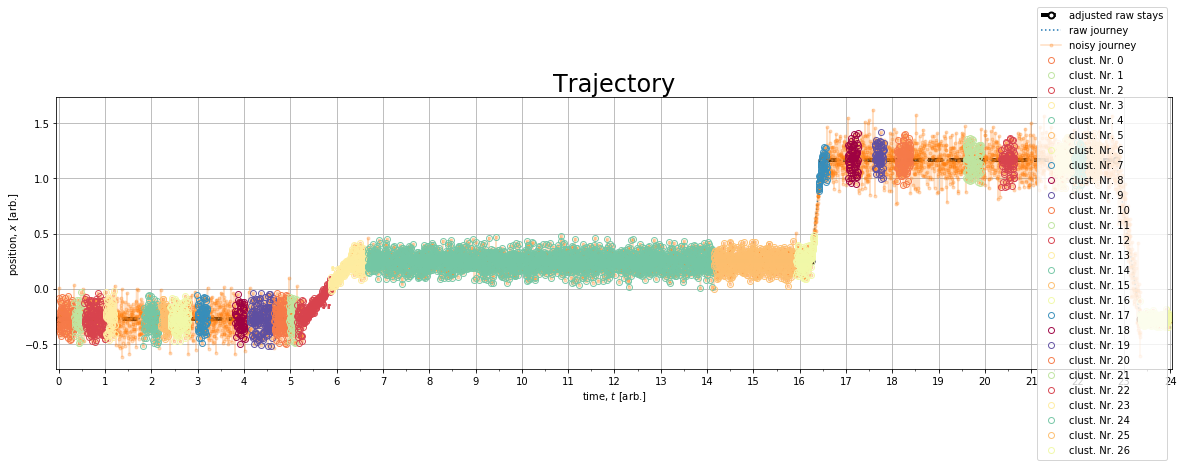

In [17]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr%len(colors)]
    
    ax.plot(time_arr[clust], noise_arr[clust], 'o', color=color, alpha=0.95, markerfacecolor="None", label=f'clust. Nr. {cl_nr}')
    
    clust_med = np.median(noise_arr[clust])    
    ax.plot([time_arr[clust[0]],time_arr[clust[-1]]], [clust_med,clust_med], '--', color=color, alpha=0.95, label=None)
    
    clust_mean = np.mean(noise_arr[clust])    
    ax.plot([time_arr[clust[0]],time_arr[clust[-1]]], [clust_mean,clust_mean], '--', dashes=[0.5, 0.5], lw=5, color=color, alpha=0.95, label=None)
    
ax.legend(loc=7);

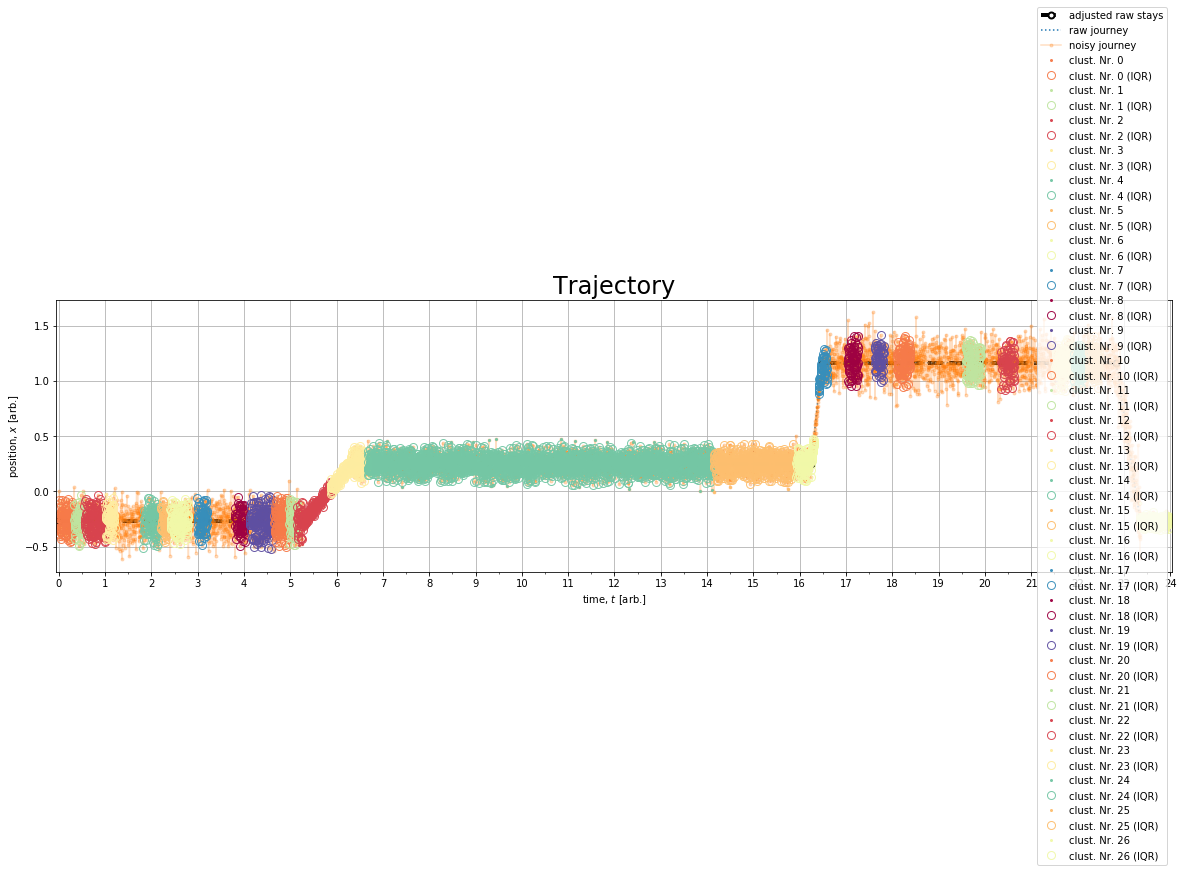

In [19]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr%len(colors)]  
    
    # Get the subseqs
    xs = time_arr[clust]
    ys = noise_arr[clust]

    # Mask to include only events within the IQR
    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')
    iqr = abs(q75 - q25)
    iqr_fact = 1.5
    
    # Apply the "without" mask
    mask=np.where((ys <= (q25 - iqr_fact * iqr)) | (ys >= (q75 + iqr_fact * iqr)))
    ax.plot(xs[mask], ys[mask], '.', alpha=0.95, color=color, markersize=4.0, label=f'clust. Nr. {cl_nr}')
    
    # Apply the "within" mask    
    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))        
    ax.plot(xs[mask], ys[mask], 'o', color=color, markersize=8.0, alpha=0.95, markerfacecolor="None", label=f'clust. Nr. {cl_nr} (IQR)')
        
ax.legend(loc=7);

### Evaluation

**NOTE** there's no classification; there's only clusters! All points are considered elements of stays.

In [20]:
final_pairs = []
for clust in clusters:
    final_pairs.append([clust[0],clust[-1]])

pred_labels = np.zeros(time_arr.shape)
for pair in final_pairs:
    pred_labels[pair[0]:pair[1]+1] = 1

In [21]:
from synthetic_data.trajectory import get_stay_indices

In [22]:
true_indices = get_stay_indices(get_adjusted_stays(segments, time_arr), time_arr)
true_labels = np.zeros(time_arr.shape)

In [23]:
for pair in true_indices:
    true_labels[pair[0]:pair[1]+1] = 1

In [24]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

In [25]:
prec = precision_score(true_labels, pred_labels)
rec  = recall_score(true_labels, pred_labels)

print(prec)
print(rec)

confusion_matrix(true_labels, pred_labels)
#prec_scores.append(prec)
#reca_scores.append(rec)

0.9327545382794001
0.7399198597545705


array([[ 228,  426],
       [2077, 5909]])

## With refinement

In [26]:
from stay_classification.splitting_classifier.splitting_classifier import get_batch_clusters, get_iqr_masked, get_iqr_std

In [27]:
clusters = get_batch_clusters(time_arr,noise_arr, eps, time_thresh, 1.5)
len(clusters)

4

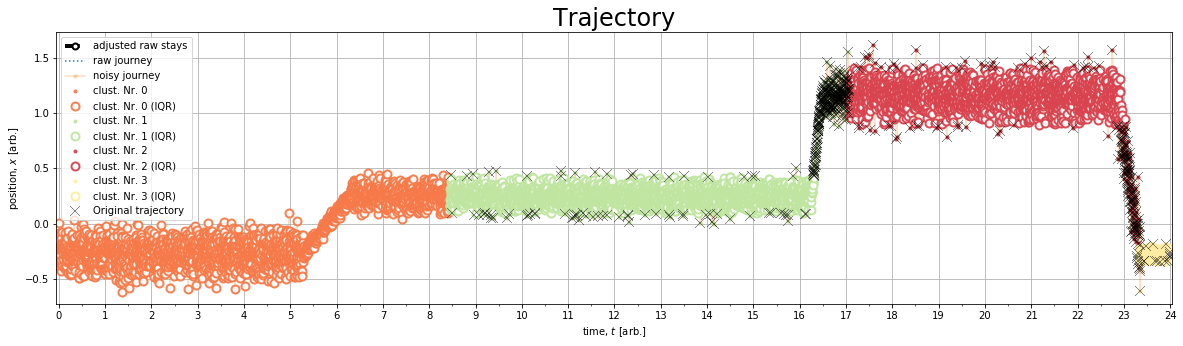

In [28]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

iqr_points_kwargs={'marker':'o', 'markeredgewidth':2.0, 'markerfacecolor':'w', 
                   'linestyle':'', 'color':'k', 'markersize':8.0, 'alpha':0.95, 
                   'label':'label'}

all_points_kwargs={'marker':'.', 'markeredgewidth':2.0, 'markerfacecolor':'w', 
                   'linestyle':'', 'color':'k', 'markersize':4.0, 'alpha':0.95, 
                   'label':'label'}

    
def get_new_kwargs(kwargs_dct):
    
    def meth(color, label):
        kwargs_dct.update({'color':color,'label':label})
        return kwargs_dct
    return meth
        
pdf = pd.DataFrame()
pdf_all = pd.DataFrame({'x':time_arr,'y':noise_arr})

for cl_nr, clust in enumerate(clusters):
    
    color=colors[cl_nr%len(colors)]   
    
    xs = time_arr[clust]
    ys = noise_arr[clust]
    
    label=f'clust. Nr. {cl_nr}'
    ax.plot(xs, ys, **get_new_kwargs(all_points_kwargs)(color,label))
    
    label=f'clust. Nr. {cl_nr} (IQR)'
    mask=get_iqr_masked(ys,1)
    ax.plot(xs[mask], ys[mask], **get_new_kwargs(iqr_points_kwargs)(color,label))

    pdf1  = pd.DataFrame({'x':xs[mask],'yy':ys[mask]})
    #pdf2  = pd.DataFrame({'x':rxs[rmask],'y':rys[rmask]})
    #pdf = pdf1.merge(pdf2, on=['x'], how='outer')
    pdf = pd.concat([pdf,pdf1])

# plot the rest of the samples
pdf_all = pdf_all.merge(pdf, on=['x'], how='outer')
pdf_all['keep'] = pdf_all.yy.apply(np.isnan)
pdf_sub = pdf_all[pdf_all['keep']]
ax.plot(pdf_sub.x.values, pdf_sub.y.values, alpha=0.95, linestyle='',color='k', marker='x', markersize=10.0, markeredgewidth=0.40, linewidth=0.50, label='Original trajectory')

ax.legend();

In [29]:
clusters_rev = get_batch_clusters(np.max(time_arr)-time_arr[::-1],noise_arr[::-1],0.6,time_thresh, 1.5)
len(clusters_rev)

2

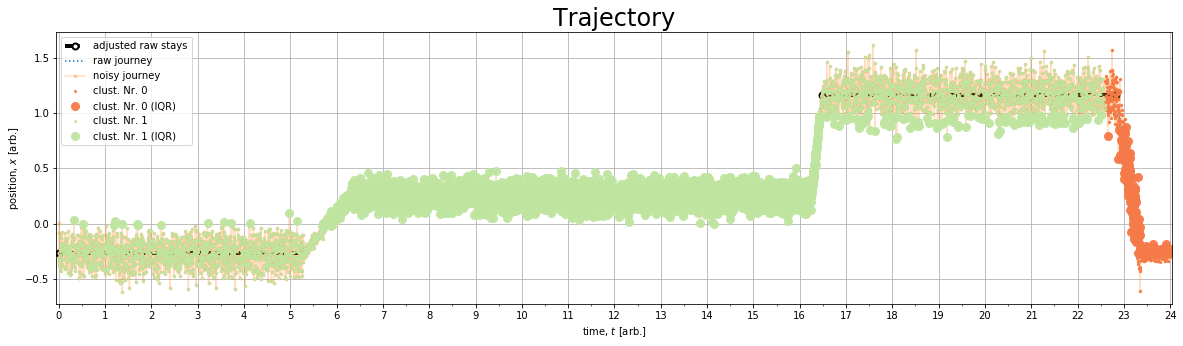

In [30]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

for cl_nr, clust in enumerate(clusters_rev):
    
    xs = time_arr[::-1][clust]
    ys = noise_arr[::-1][clust]
    
    ax.plot(xs, ys, '.', alpha=0.95, color=colors[cl_nr], markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    iqr_fact = 0
    
    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    color=colors[cl_nr%len(colors)]  
    ax.plot(xs[mask], ys[mask], 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    
ax.legend();

22.593333333333334 0.008611111111111111
0.008611111111111111 22.593333333333334
23.9975 22.593333333333334
22.593333333333334 23.9975


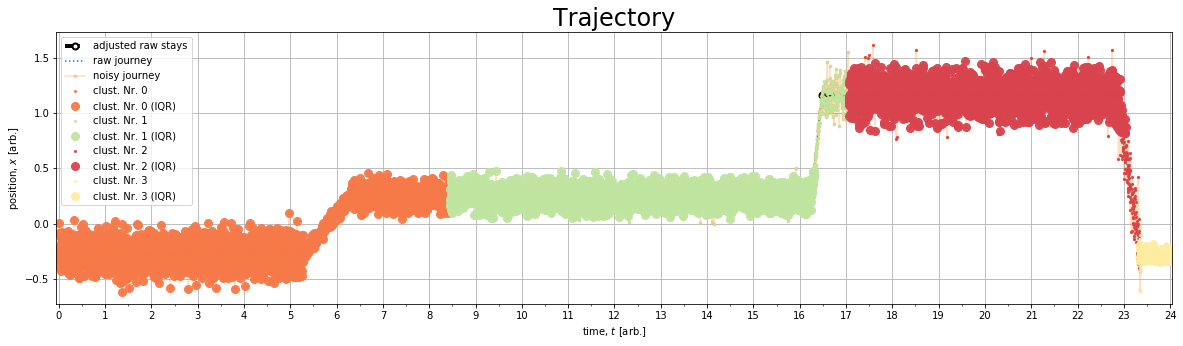

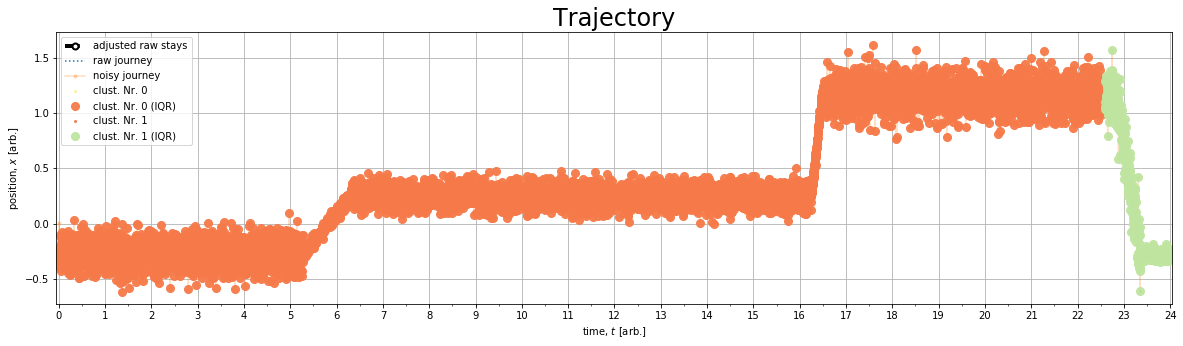

In [31]:

ax = np.array([None,None])
ax = ax.reshape(2,)

ax[0] = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

ax[1] = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

for cl_nr, clust in enumerate(clusters):
    
    xs = time_arr[clust]
    ys = noise_arr[clust]
    color=colors[cl_nr%len(colors)]    
    ax[0].plot(xs, ys, '.', alpha=0.95, color=color, markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 1.5

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    color=colors[cl_nr%len(colors)]
    ax[0].plot(xs[mask], ys[mask], 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[0].legend()
    
for cl_nr, clust in enumerate(clusters_rev[::-1]):

    xs = time_arr[::-1][clust]
    ys = noise_arr[::-1][clust]
    
    print(xs[0],xs[-1])    
    xs = xs[::-1]
    print(xs[0],xs[-1])
    
    ys = ys[::-1]
    ax[1].plot(xs, ys, '.', alpha=0.95, color=color, markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 1.5

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    color=colors[cl_nr%len(colors)]    
    ax[1].plot(xs[mask], ys[mask], 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[1].legend();

## Notes
* need to ensure the time-backward trajectory works in roughly the same way as the time-forward one
* need to have something that merges nearby clusters if they are close enough in time and space

22.593333333333334 0.008611111111111111
0.008611111111111111 22.593333333333334
23.9975 22.593333333333334
22.593333333333334 23.9975
0.0019444444444444444 8.453611111111112
0.0019444444444444444 8.453611111111112
8.453611111111112 17.06138888888889
8.453611111111112 17.06138888888889


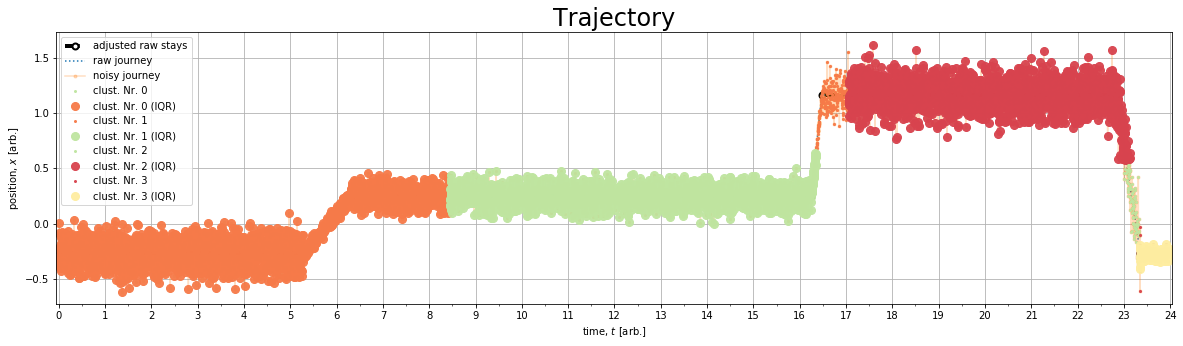

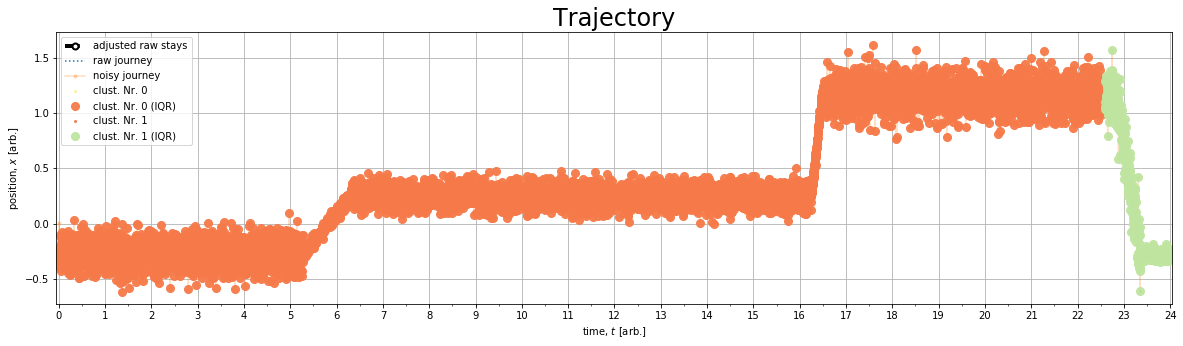

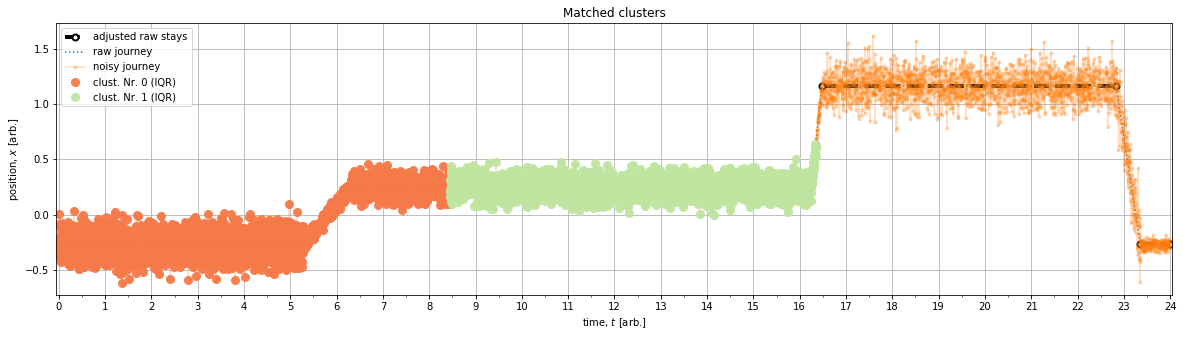

In [32]:
ax = np.array([None,None,None])
ax = ax.reshape(3,)

ax[0] = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

ax[1] = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

ax[2] = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);


get_match = lambda x,y: (np.isnan(x) | np.isnan(x))
get_val = lambda x,y: x if np.isnan(x)==False else y

cl_nr = 0


for cl_nr, clust in enumerate(clusters):
    
    xs = time_arr[clust]
    ys = noise_arr[clust]
    
    ax[0].plot(xs, ys, '.', alpha=0.95, color=color, markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    color=colors[cl_nr%len(colors)]    
    ax[0].plot(xs[mask], ys[mask], 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[0].legend()
    
for cl_nr, clust in enumerate(clusters_rev[::-1]):

    xs = time_arr[::-1][clust]
    ys = noise_arr[::-1][clust]
    
    print(xs[0],xs[-1])    
    xs = xs[::-1]
    print(xs[0],xs[-1])
    
    ys = ys[::-1]
    ax[1].plot(xs, ys, '.', alpha=0.95, color=color, markersize=4.0, label=f'clust. Nr. {cl_nr}')

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    color=colors[cl_nr%len(colors)]    
    ax[1].plot(xs[mask], ys[mask], 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    ax[1].legend();
    
cl_nr = 0
for clust, rclust in zip(clusters,clusters_rev[::-1]):
    
    xs = time_arr[clust]
    ys = noise_arr[clust]
    
    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    
    pdf1  = pd.DataFrame({'x':xs[mask],'y':ys[mask]})

    
    rxs = time_arr[::-1][rclust]
    rys = noise_arr[::-1][rclust]
    
    print(xs[0],xs[-1])    
    rxs = rxs[::-1]
    print(xs[0],xs[-1])
    
    rys = rys[::-1]

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    rmask=np.where((rys > (q25 - iqr_fact * iqr)) & (rys < (q75 + iqr_fact * iqr)))

    
    pdf2  = pd.DataFrame({'x':rxs[rmask],'ry':rys[rmask]})    
    
    pdf = pdf1.merge(pdf2, on=['x'], how='outer')
    #pdf = pd.concat([pdf,pdf1.merge(pdf2, on=['x'], how='outer')])
    
    pdf['matched'] = pdf.apply(lambda x: get_match(x['y'],x['ry']), axis=1)
    pdf['yy'] = pdf.apply(lambda x: get_val(x['y'],x['ry']), axis=1)

    color=colors[cl_nr%len(colors)]    
    ax[2].plot(pdf[pdf['matched']==False].x.values, pdf[pdf['matched']==False].y.values, 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
    
    #ax[2].plot(pdf[pdf['matched']].x.values, pdf[pdf['matched']].yy.values, '.', alpha=0.95, color='k', markersize=4.0, label=None)


    ax[2].legend();    
    ax[2].set_title('Matched clusters')
    
    cl_nr += 1

In [33]:
pdf.head()

,x,y,ry,matched,yy
0,8.453611,0.169827,NaN,False,0.169827
1,8.454722,0.310144,NaN,False,0.310144
2,8.455556,0.226020,NaN,False,0.226020
3,8.457778,0.162508,NaN,False,0.162508
4,8.459444,0.209926,NaN,False,0.209926


In [90]:
cl_nr = 0

pdf_fout = pd.DataFrame()
pdf_f  = pd.DataFrame({'t':time_arr,'x':noise_arr})
#pdf_f['stay'] = False

for clust in clusters:
    
    xs = time_arr[clust]
    ys = noise_arr[clust]
    
    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    mask=np.where((ys > (q25 - iqr_fact * iqr)) & (ys < (q75 + iqr_fact * iqr)))
    
    pdf1  = pd.DataFrame({'t':xs[mask],'x':ys[mask]})

    pdf1['stay_f'] = True
    
    pdf_fout = pd.concat([pdf_fout, pdf_f.merge(pdf1, on=['t', 'x'], how='outer')])

In [91]:
pdf_fout.fillna(False, inplace=True)

In [93]:
pdf_fout.tail(50)

,t,x,stay_f
8590,23.870000,-0.267532,True
8591,23.873333,-0.228224,True
8592,23.879444,-0.311538,True
8593,23.883611,-0.316184,True
8594,23.887778,-0.236352,True
8595,23.888611,-0.291740,True
8596,23.889167,-0.238108,True
8597,23.890556,-0.218253,True
8598,23.891111,-0.341816,True
8599,23.894167,-0.271553,True


Text(0.5, 1.0, 'Matched clusters')

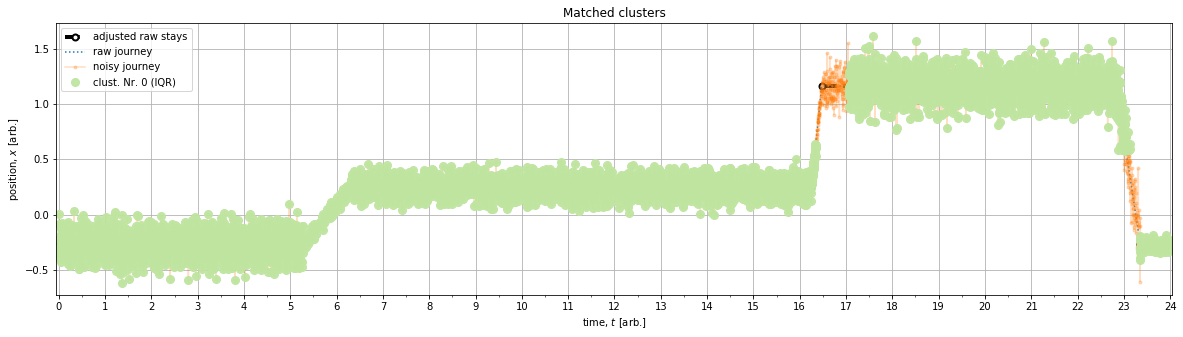

In [94]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

ax.plot(pdf_fout[pdf_fout['stay_f']==True].t.values, \
        pdf_fout[pdf_fout['stay_f']==True].x.values, 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
ax.legend();    
ax.set_title('Matched clusters')


In [104]:
len(clusters_rev)

2

In [97]:
cl_nr = 0

pdf_rout = pd.DataFrame()
pdf_r  = pd.DataFrame({'t':time_arr,'x':noise_arr})
#pdf_f['stay'] = False

for rclust in clusters_rev[::-1]:
    
    rxs = time_arr[::-1][rclust]
    rys = noise_arr[::-1][rclust]
    
    print(xs[0],xs[-1])    
    rxs = rxs[::-1]
    print(xs[0],xs[-1])
    
    rys = rys[::-1]

    q25 = np.quantile(ys,0.25, interpolation='lower')
    q75 = np.quantile(ys,0.75, interpolation='higher')

    iqr = abs(q75 - q25)
    iqr_fact = 3

    rmask=np.where((rys > (q25 - iqr_fact * iqr)) & (rys < (q75 + iqr_fact * iqr)))

    pdf1  = pd.DataFrame({'t':xs[mask],'x':ys[mask]})

    pdf1['stay_r'] = True
    
    pdf_rout = pd.concat([pdf_rout, pdf_r.merge(pdf1, on=['t', 'x'], how='outer')])

23.33861111111111 23.98361111111111
23.33861111111111 23.98361111111111
23.33861111111111 23.98361111111111
23.33861111111111 23.98361111111111


In [98]:
pdf_rout[pdf_rout['stay_r']==False].count()

t         0
x         0
stay_r    0
dtype: int64

In [99]:
pdf_rout.fillna(False, inplace=True)

Text(0.5, 1.0, 'Matched clusters')

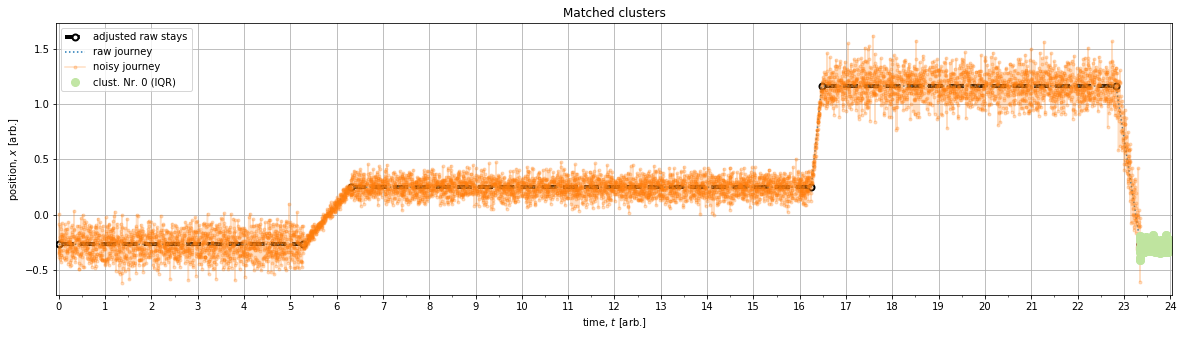

In [100]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

ax.plot(pdf_rout[pdf_rout['stay_r']==True].t.values, \
        pdf_rout[pdf_rout['stay_r']==True].x.values, 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
ax.legend();    
ax.set_title('Matched clusters')


In [78]:
pdf_fout.shape, pdf_rout.shape

((17280, 3), (17280, 3))

In [79]:
pdf_mrg = pdf_fout.merge(pdf_rout, on=['t','x'], how='inner')

In [80]:
pdf_mrg['stay'] = pdf_mrg.apply(lambda x: (x['stay_f']) & (x['stay_r']), axis=1)

In [81]:
pdf_mrg.head()

,t,x,stay_f,stay_r,stay
0,0.001944,0.004485,True,False,False
1,0.001944,0.004485,True,False,False
2,0.001944,0.004485,False,False,False
3,0.001944,0.004485,False,False,False
4,0.003611,-0.306725,True,False,False


Text(0.5, 1.0, 'Matched clusters')

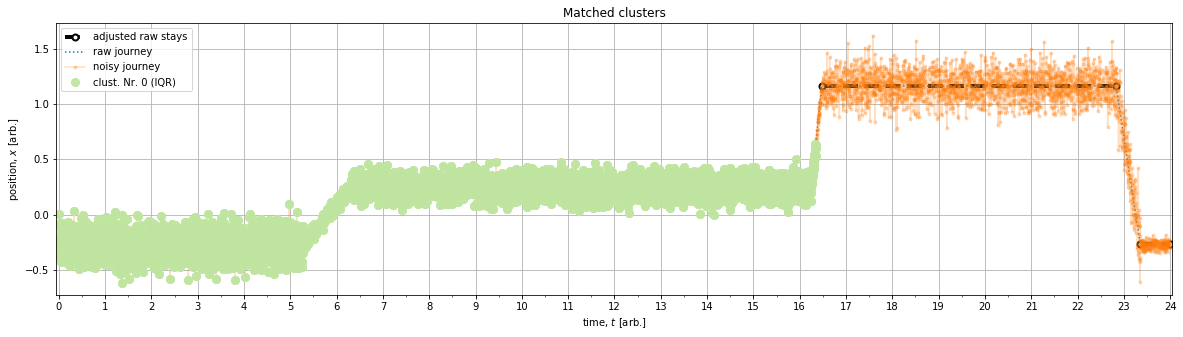

In [86]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

ax.plot(pdf_mrg[pdf_mrg['stay_f']==True].t.values, \
        pdf_mrg[pdf_mrg['stay_f']==True].x.values, 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
ax.legend();    
ax.set_title('Matched clusters')


Text(0.5, 1.0, 'Matched clusters')

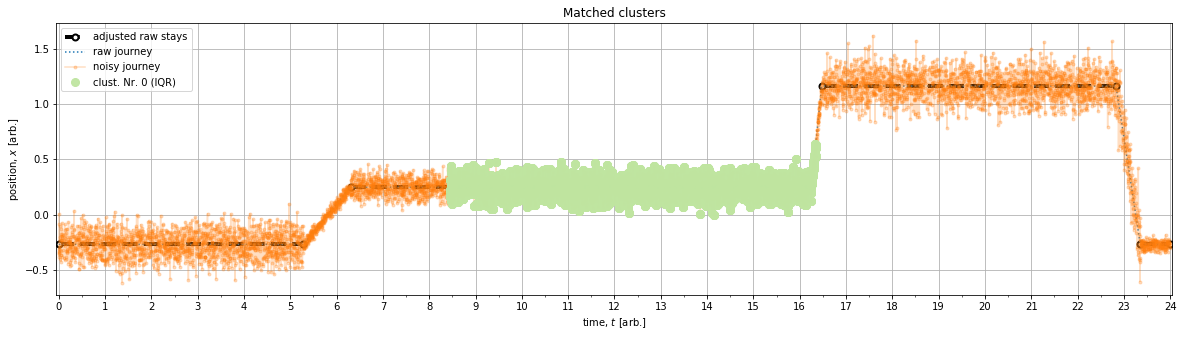

In [87]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

ax.plot(pdf_mrg[pdf_mrg['stay_r']==True].t.values, \
        pdf_mrg[pdf_mrg['stay_r']==True].x.values, 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
ax.legend();    
ax.set_title('Matched clusters')


Text(0.5, 1.0, 'Matched clusters')

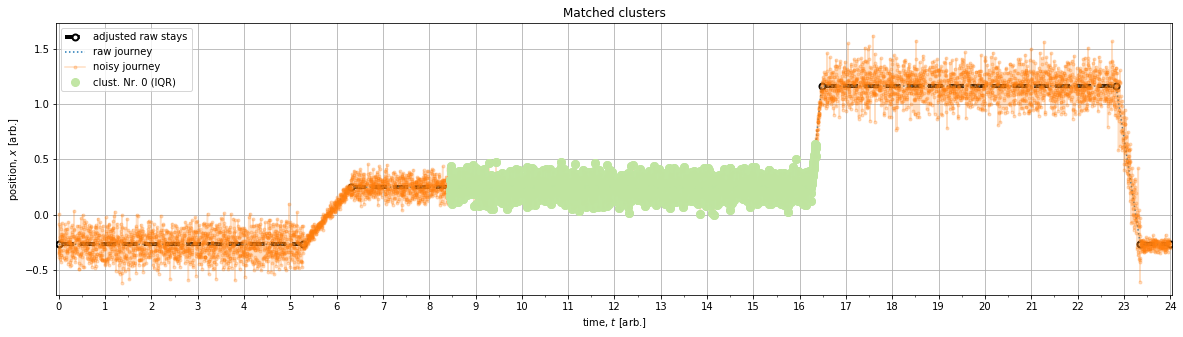

In [85]:
ax = plot_trajectory(time_arr, raw_arr, noise_arr, t_segs, x_segs, configs['dist_thresh']);

ax.plot(pdf_mrg[pdf_mrg['stay']==True].t.values, \
        pdf_mrg[pdf_mrg['stay']==True].x.values, 'o', color=color, markersize=8.0, alpha=0.95, label=f'clust. Nr. {cl_nr} (IQR)')
ax.legend();    
ax.set_title('Matched clusters')
